# Imports and Warnings

In [1]:
import sys
import os
import re
import csv
import shutil
import heapq
import codecs
import json
from collections import Counter, OrderedDict, defaultdict
from pathlib import Path #Convert all directory accesses to this
from functools import reduce
import glob

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate

import pickle
import warnings

pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Functions

In [2]:
def createFullDirectory(mainDirectory,subDirectory):
    #
    # This function is used to concatenate two directories
    #
    return str(mainDirectory+subDirectory)

def createFullPathToFile(fullDirectory, fileName):
    #
    # This function is used to concatenate a directory and filename
    #
    return str(fullDirectory+fileName)

def listFilesInDirectory(directoryContainingFiles):
    #
    # This returns a list() of the names of files in a directory
    #
    return glob.glob(directoryContainingFiles) 

def stripFilePathAndExtension(filePath):
    #
    # This returns the filename without the path and extension
    #
    return Path(filePath).stem

def replaceFilePathAndExtension(filePath, prefixToInsert, suffixToInsert):#filePath, prefixToStrip, prefixToInsert, suffixToStrip, suffixToInsert):
    #
    # This replaces the file path and extension with the given replacements
    #
    filePath = Path(filePath).stem
    filePath = prefixToInsert+filePath+suffixToInsert
    return filePath

def printDataFrame(dataframe):
    #
    # This pretty prints a dataframe
    #
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(dataframe)

def zeroOutDataframe(dataframe):
    #
    # This fills null cells in a dataframe with zeros
    #
    dataframe = dataframe.fillna(0)
    return dataframe

def countEntriesInDataframe(dataframe):
    #
    # This counts the amount of non-zero cells in a dataframe
    #
    return np.count_nonzero(dataframe)

def sortDictionary(dictionary):
    #
    # This sorts a dictionary in ascending order
    #
    returnVal = sorted(dict(Counter(dictionary)).items(), key=lambda kv:
                 (kv[1], kv[0]))
    return returnVal

def fileNewlineIntoList(filePath):
    #
    # This takes a filepath as a parameter and returns the contents of the file in a list, seperated by newline
    #
    lineList = []
    with open(filePath) as openFile:
        for line in openFile:
            temp = line.strip()
            lineList.append(temp)
    return lineList

def stripNewlineAndWhitespace(textStringToStrip):
    #
    # This removes the whitespace and newlines from a string
    #
    textStringToStrip = textStringToStrip.replace("\t","")
    textStringToStrip = textStringToStrip.replace("\n","")
    textStringToStrip = textStringToStrip.replace(" ","")
    return textStringToStrip

def stripNewlineAndWhitespaceFromList(listToStrip):
    #
    # This removes the whitespace and newlines from every string in a list
    #
    for i in range(0,len(listToStrip)):
        listToStrip[i] = stripNewlineAndWhitespace(listToStrip[i])
    return listToStrip

def regexSearchFile(filePath, regexPattern):
    #
    # This returns all of the matches in a file that match the given regex pattern
    #
    with open(filePath) as openFile:
        matches = re.findall(regexPattern, openFile.read())
    openFile.close()
    return matches

def cleanFileNameList(fileNameList,malwareClass, sortedDatasetDirectory): #NEED TO PORT THIS
    #
    # NEED TO FIX THIS
    #
    filePathToNameDict = {}
    for i in range(0, len(fileNameList)): 
        strippedFile = stripFilePathAndExtension(fileNameList[i])
        filePathToNameDict[strippedFile] = fileNameList[i]
        fileNameList[i] = strippedFile
    return fileNameList

def generateClassDataFrame(listColumnsToUse,listRowsToUse):
    #
    # This creates an empty dataframe using two lists for the columns and index respectively
    #
    return zeroOutDataframe(pd.DataFrame(columns=listColumnsToUse,index=listRowsToUse))

def moveFilesToClassFolders(backupFileList, fullFileNamesListFromCSV, unsortedDataset,sortedDataset):
    #
    # This reads the CSV mapping filenames to classes
    # It iterates through the CSV's index to run an operation on every file
    # The operation gets the filename alone and tries to copy it to it's folder
    # The folder is determined by using a lookup of that clean filename in the index and checking the cell value of that index
    #
    fullFileNamesListFromCSV.set_index("Id",inplace=True)
    for fileIndex in range(0,len(backupFileList)): # file is the full path to the file, fileClean is just the name of the file without extension
        fileClean = stripFilePathAndExtension(backupFileList[fileIndex])#,unsortedDataset,".asm") #This is to try fix an error
        try:
            shutil.copyfile(backupFileList[fileIndex],sortedDataset+"class-"+str(fullFileNamesListFromCSV.loc[fileClean,"Class"])+"/"+str(fullFileNamesListFromCSV.loc[fileClean].name)+".asm")
        except:
            fileIndex = fileIndex + 1

def generateFilenameToDirectoryDict(listOfFiles):
    #
    # This takes a list of files in a directory
    # It then creates a dictionary that maps the clean names to the paths
    #
    filePathToNameDict = {}
    for file in listOfFiles:
        filePathToNameDict[Path(file).stem] = file
    return filePathToNameDict

def populateMalwareDataframe(fileDirectoryTopLevel,instructionList):
    #
    # FILL THIS IN
    #

    filePathToNameDict = generateFilenameToDirectoryDict(listFilesInDirectory(fileDirectoryTopLevel))
    dataFrame = zeroOutDataframe(pd.DataFrame(columns=instructionList,index=filePathToNameDict.keys()))

    for file in filePathToNameDict.keys(): # Go through every file in our directory
        fileDirectory = filePathToNameDict[file] # Convert using dict here
        instructionsForThisFile = stripNewlineAndWhitespaceFromList(regexSearchFile(fileDirectory,"(?:\t{3,7}       (?!db|dd)[a-zA-Z]{2,6} {1,})")) # cleaning and pulling instructions

        pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up   
        for i in range(0, len(pandasSeriesTest[0])):
            dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
        
        #Optional cleaning options for my DF to merge dupe columns and group them up
        dataFrame = dataFrame.groupby(axis=1, level=0).sum() # Merges dupe columns
        #dataFrame = dataFrame.loc[:, (dataFrame != 0).any(axis=0)] # Removes columns with no values
    return dataFrame

def classDataFrameCompletion(instructionList,sortedDataset,classList,classInteger):
    #
    # FILL THIS IN
    #
    
    dataFrameInFunction = generateClassDataFrame(
        instructionList,      # This is the instruction list
        cleanFileNameList(    # This is the list of files
            listFilesInDirectory(sortedDataset+classList[classInteger-1]+"/*.asm"),  # This is the directory containing the files
            classInteger,
            sortedDataset))  #This is the malware class for cleanFileNameList
    
    dataFrameInFunction = populateMalwareDataframe(
                            sortedDataset+classList[classInteger-1]+"/*.asm",
                            instructionList)

    dataFrameInFunction = zeroOutDataframe(dataFrameInFunction)
    
    dataFrameInFunction.loc[~(dataFrameInFunction==0).all(axis=1)]
    
    dataFrameInFunction.insert(0,"class",classInteger)

    return dataFrameInFunction

def removeNanValuesFromDataframe(dataframeToSanitise):
    #
    # This sanitises the DF be replacing NAN values with zero
    #
    dataframeToSanitise = dataframeToSanitise.replace(np.nan,0)
    return dataframeToSanitise

def normaliseData(dataframeToNormalise):
    #
    # This is the normalisation function that can be used to normalise data before it is fed into the model
    #

    #return (data -trainStats["mean"]) / trainStats['std'] #Works fine, the below approach is better and more portable however
    #return data.div(data.sum(axis=1), axis=0)

    dataframeToNormalise = removeNanValuesFromDataframe(dataframeToNormalise)
    return dataframeToNormalise
    
def modelSVMClassifierCreate(cValue, kernelType):
    #
    # This returns an SVM model object using the C value and the kernel type
    #
    return svm.SVC(C=cValue, kernel=kernelType)
    
def svmModelFit(modelToFit,trainingDataframe, trainingDatasetLabels):
    #
    # This fits an SVM model to a dataset alongside the labels for training
    #
    return modelToFit.fit(trainingDataframe, trainingDatasetLabels)

def svmModelPredict(modelForPrediction, dataframeToPredictWith):
    #
    # This takes a model and a dataframe to make predictions for each of the values in the dataframe
    #
    return modelForPrediction.predict(dataframeToPredictWith)

def svmModelTrain(cValue, kernelType, trainingDataframe, trainingLabels):
    #
    # This creates and fits a model by taking the c value, kernel type and the training data
    #
    return svmModelFit(
                modelSVMClassifierCreate(
                    cValue, 
                    kernelType), 
                trainingDataframe, 
                trainingLabels)
     
def trainAndPredictModel(cValue, kernelType, trainingDataframe, trainingLabels):
    #
    # This trains the model using the previous functions and creates a prediction, returning the prediction and the model
    #
    model = modelSVMClassifierCreate(cValue, kernelType)
    model = svmModelFit(model, trainingDataframe, trainingLabels)
    modelPrediction = svmModelPredict(model, trainingDataframe)

    print(kernelType+" Kernel Type - Training Dataset - Accuracy vs Labels: "+str(metrics.accuracy_score(trainingLabels,modelPrediction))+"")

    return modelPrediction, model

def createSVMConfusionMatrix(predictResults, fileClassList):
    #
    # This creates a confusion matrix for a given set of results, with the fileClassList for the tick labels
    #

    for i in range(0, len(fileClassList)): fileClassList[i] = fileClassList[i][-1]#; fileClassList[i] = int(fileClassList[i])

    ax = plt.subplot()
    cm = confusion_matrix(predictResults,predictResults)

    ax.set_xlabel("Predicted Labels") # Doesn't work
    ax.set_ylabel("True Labels") # Doesn't work
    ax.set_title("Confusion Matrix - Linear")

    sns.heatmap(cm, annot=True, ax=ax, yticklabels=fileClassList, xticklabels=fileClassList); #Semicolon removes the annoying text above the graph

def classificationReportGenerateGraph(testLabels,svmTestDatasetPrediction):
    #
    # This creates a graph to show off the classification report for the model
    #
    classificationReportDF = pd.DataFrame(classification_report(testLabels,svmTestDatasetPrediction,output_dict=True)).transpose()[:9]
    classificationReportF1Supp = classificationReportDF
    classificationReportF1Supp = classificationReportF1Supp[classificationReportF1Supp.columns[2:4]]
    classificationReportF1Supp["support"] = classificationReportF1Supp["support"].astype(int).div(100)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(
        x=classificationReportF1Supp.index.values.tolist(), 
        height=classificationReportF1Supp["f1-score"], 
        width=0.5, 
        align='center')

    ax.bar(
        x=classificationReportF1Supp.index.values.tolist(), 
        height=classificationReportF1Supp["support"], 
        width=0.35, 
        align='center')

    f1ScoreBar = mpatches.Patch(color='blue', label="f1 score")
    supportScoreBar = mpatches.Patch(color='orange', label="support")
    ax.legend(handles=[f1ScoreBar, supportScoreBar],bbox_to_anchor=(0.5, -0.055), loc="upper center",ncol=2)
    ax.set_title("A graph demonstrating the relationship between F1 scores and support")

    plt.tight_layout()
    plt.show()

def permutationImportanceGraphPlot(model, normalisedTrainDF, trainLabels, finalDF):
    #
    # This takes the model and relevant data to derive the permutation importance for a linear SVM Model
    #
    normalisedTrainDFNoClass = normalisedTrainDF.copy()
    permutationImportance = permutation_importance(model, normalisedTrainDFNoClass, trainLabels)
    featuresList = np.array(list(normalisedTrainDFNoClass.columns))
    sortedIDX = permutationImportance.importances_mean.argsort()
    mostImportantIndexesPermutation = [list(permutationImportance.importances_mean[sortedIDX]).index(i) for i in heapq.nlargest(30, permutationImportance.importances_mean[sortedIDX])]

    ### Showing the largest features
    newFeaturesList = []
    newPermutationImportanceList = []

    for i in mostImportantIndexesPermutation[::-1]:
        newFeaturesList.append(featuresList[sortedIDX][i])
        newPermutationImportanceList.append(permutationImportance.importances_mean[sortedIDX][i])

    occurancesQuantity={}
    for i in newFeaturesList[::-1]:
        occurancesQuantity.update({i:str(int(finalDF[i].mean()))})

    #print(newPermutationImportanceList[::-1]) #This gets the raw values of the graph
    #print(occurancesQuantity[::-1]) # This slice needs to be converted to a string, it is list of names that maps to raw values above

    from sklearn import preprocessing
    plt.subplot(1, 2, 1)
    plt.barh(newFeaturesList, newPermutationImportanceList);
    plt.xlabel("Permutation Importance/Feature");
    plt.margins(x=0)
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5],["0","0.2","0.4","0.6","0.8","1"])

    plt.subplot(1, 2, 2)
    plt.barh(list(occurancesQuantity.keys())[::-1], preprocessing.minmax_scale(list(occurancesQuantity.values())[::-1],feature_range=(0,0.5)));
    plt.xlabel("Mean Relative occurances/Feature");
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5],["0","0.2","0.4","0.6","0.8","1"])
    plt.margins(x=0)
    plt.tight_layout()

def setupSanitisedDatasetSubset(sortedDataset, classList):
    #
    # This is used to limit the amount of files in a given class to 250 or less to maintian a manageable dataset
    #
    for fileClass in classList:
        directory = str(sortedDataset+fileClass+"/*")
        fileList = listFilesInDirectory(directory)

        i = 0
        for i in range(0,len(fileList)):
            if(i >= 250):
                os.remove(fileList[i])
        print(len(listFilesInDirectory(sortedDataset+classList[0]+"/*.asm")))

def pickleSaveModel(model, modelSaveLocation):
    #
    # This serialises a model and saves it to the disk
    #
    pickle.dump(model, open(modelSaveLocation, "wb"))

def pickleLoadModel(modelLoadLocation):
    #
    # This is used to read a serialised model and import a trained SVM model
    #
    return pickle.load(open(modelLoadLocation,"rb"))

def collectTrainingData(workingDirectory, sortedDataset, classList, instructionList):
    #
    # This returns an array of the populated datasets for each of the nine classes
    #
    #instructionList = fileNewlineIntoList(workingDirectory+"instructionListComplete.txt")
    dataframeClassOne = classDataFrameCompletion(instructionList, sortedDataset, classList, 1)
    dataframeClassTwo = classDataFrameCompletion(instructionList, sortedDataset, classList, 2)
    dataframeClassThree = classDataFrameCompletion(instructionList, sortedDataset, classList, 3)
    dataframeClassFour = classDataFrameCompletion(instructionList, sortedDataset, classList, 4)
    dataframeClassFive = classDataFrameCompletion(instructionList, sortedDataset, classList, 5)
    dataframeClassSix = classDataFrameCompletion(instructionList, sortedDataset, classList, 6)
    dataframeClassSeven = classDataFrameCompletion(instructionList, sortedDataset, classList, 7)
    dataframeClassEight = classDataFrameCompletion(instructionList, sortedDataset, classList, 8)
    dataframeClassNine = classDataFrameCompletion(instructionList, sortedDataset, classList, 9)

    return [dataframeClassOne,dataframeClassTwo,dataframeClassThree,dataframeClassFour,dataframeClassFive,dataframeClassSix,dataframeClassSeven,dataframeClassEight,dataframeClassNine]

def collectCustomTrainingData(workingDirectory, customTrainingFilesList, instructionList):
    #
    # This is an attempt to allow for additions to the training set in a modular way
    #

    classifyDF = zeroOutDataframe(pd.DataFrame(columns=instructionList,index=list(customTrainingFilesList)))

    return classifyDF


def constructFinalDF(dataframesList, pickleName):
    #
    # This combines all of the datasets in the dataframe list into one
    # The function merges all of the duplicate columns, cleans any nan values and prints some basic information about the final dataframe
    #
    finalDF = pd.concat(dataframesList).drop_duplicates()
    finalDF = zeroOutDataframe(finalDF)
    finalDF.loc[~(finalDF==0).all(axis=1)]
    finalDF = finalDF.loc[:, (finalDF != 0).any(axis=0)] # Removes columns with no values
    finalDF = finalDF.sample(frac=1)
    #finalDF.info()
    #finalDF.to_pickle("./"+pickleName+".pickle")
    return finalDF

def createTrainTestValidSplits(finalDF, trainTestSplitSize, testToValidRatio):
    #
    # This returns train, test and valid dataframes in ratio 60 : 20 : 20
    #
    trainDF, testAndValidDF = train_test_split(finalDF, test_size=trainTestSplitSize) # previously 0.4 for 40% test+valid
    testDF, validDF = train_test_split(testAndValidDF, test_size=testToValidRatio) # previously 0.5 for 50-50 test-valid split of the original 40%

    print(f"Training Dataset rows and columns: {trainDF.shape}")
    print(f"Test Dataset rows and columns: {testDF.shape}")
    print(f"Validation Dataset rows and columns: {validDF.shape}")
    return trainDF, validDF, testDF

def writeTrainingStats(trainDF, writeLocation):
    #
    # Creates some basic training statistics for the training dataset
    #
    trainStats = trainDF.describe()
    trainStats.pop("class")
    trainStats = trainStats.transpose()
    trainStats.to_csv(writeLocation)

def createExamplePrediction(normalisedTestDF, model):
    #
    # This takes the first 10 entries in the test dataframe and gets predictions for them 
    #
    exampleSubsetDF = normalisedTestDF[:10]
    exampleResult = model.predict(exampleSubsetDF)
    dataFrameExampleResult = pd.Series(list(exampleSubsetDF.index),index=exampleResult)
    dataFrameExampleResult.head(10)
    
def createSetLabels(dataframe, nameOfDataframe):
    #
    # Given a dataframe, this function can create a set of labels by removing them from the original dataframe
    #
    dataframeClone = dataframe.copy()
    createdLabels = dataframeClone.pop("class")
    #print(nameOfDataframe+" data rows: "+str(len(createdLabels)))
    return createdLabels, dataframeClone

def stripInstructions(filePath):
    #
    # This function is used to pull all of the assembly instructions from a file
    # Possible not needed anymore with the objdump development 
    #
    pattern = re.compile("(?:^[a-zA-Z]{2,6}\s)")

    matches = []

    for line in enumerate(open(filePath)):
        for match in re.finditer(pattern, line):
            currentMatch = match.group()
            currentMatch = currentMatch.strip()
            matches.append(currentMatch)

def setupModelTrainingData(sortedDataset, instructionList, classList, workingDirectory, unsortedDataset, baseDirectory, customDataset, writeDFsToPickle, writeFinalDFToPickle, writeCustomFinalDFToPickle, readFinalDFFromPickle, sortFilesIntoClassFolders):
    #
    # This is the complete function to move all of the asm training data into the right place
    # It then copies the custom dataset into the training set
    # it splits the dataset into the relevant splits
    # It pickles the three dataframes after normalising then
    #
    if(sortFilesIntoClassFolders == True):
        moveFilesToClassFolders(listFilesInDirectory(unsortedDataset+"*"),pd.read_csv(baseDirectory+"trainLabels.csv"),unsortedDataset,sortedDataset)
        setupSanitisedDatasetSubset(sortedDataset, classList)
    
    
    
    if(readFinalDFFromPickle == True):
        # This case just reads the pickles from the local directory
        finalDF = pd.read_pickle(workingDirectory+"finalDF.pickle")
        finalDFCustom = pd.read_pickle(workingDirectory+"finalDFCustom.pickle")
    else:
        # Each of the 9 classes has a dataframe created and populated, these 9 populated dataframes are returned as a list
        dataframesList = collectTrainingData(workingDirectory, sortedDataset, classList, instructionList)
        # This function takes the 9 dataframes as a list and merges them into one dataframe for use with the model
        finalDF = constructFinalDF(dataframesList, "finalDF")
        # This function is used to generate 9 dataframes - One for each class using the custom dataset that the user can modify
        dataframesListCustom = collectTrainingData(workingDirectory,customDataset,classList, instructionList)
        # This merges the 9 dataframes that are using the custom dataframes
        finalDFCustom = constructFinalDF(dataframesListCustom, "finalDFCustom")

        # If the switch is provided, these two dataframes are pickled and saved to the disk, allowing for quick use in the future
        if(writeFinalDFToPickle == True): finalDF.to_pickle(workingDirectory+"finalDF.pickle")
        if(writeCustomFinalDFToPickle == True): finalDFCustom.to_pickle(workingDirectory+"finalDFCustom.pickle")

    # The splits are generated here to train and evaluate model performance - This is only done with the base dataset
    trainDF, validDF, testDF = createTrainTestValidSplits(finalDF, float(0.3), float(0.2))

    # Erronous values are removed from each of the split frames to ensure there are no errors when fitting the model to the data
    normalisedTrainDF = normaliseData(trainDF)
    normalisedValidDF = normaliseData(validDF)
    normalisedTestDF = normaliseData(testDF)
    
    # If the switch is provided, the split dataframes can be saved to the disk
    if(writeDFsToPickle == True):
        normalisedTrainDF.to_pickle(workingDirectory+"trainDF.pickle")
        normalisedValidDF.to_pickle(workingDirectory+"validDF.pickle")
        normalisedTestDF.to_pickle(workingDirectory+"testDF.pickle")
    # Each of the splits and the two main dataframes are returned
    return normalisedTrainDF, normalisedValidDF, normalisedTestDF, finalDF, finalDFCustom

def loadModelTrainingDataFromPickle(workingDirectory):
    #
    # This loads the pickle files for the three types of dataframes
    #   
    trainingData = pd.read_pickle(workingDirectory+"trainDF.pickle")
    validationData = pd.read_pickle(workingDirectory+"validDF.pickle")
    testingData = pd.read_pickle(workingDirectory+"testDF.pickle")
    return trainingData, validationData, testingData

def customPopulateMalwareClassifyDataframe(fileDirectoryTopLevel, instructionList, classList, trainDF):
    #
    # This is responsible for going through the custom malware dataset and populating an array of DFs with the information of each custom class of malware
    #
    customDFs = []
    
    cleanFileNameList = listFilesInDirectory(fileDirectoryTopLevel+"/*")
    for x in range(0,len(cleanFileNameList)): cleanFileNameList[x] = stripFilePathAndExtension(cleanFileNameList[x])
        #print(cleanFileNameList)
    customDFs.append(zeroOutDataframe(generateClassDataFrame(trainDF.columns,cleanFileNameList)))

    for file in listFilesInDirectory(fileDirectoryTopLevel+"/*"):
        instructions = fileNewlineIntoList(file)
        instructionQuantities = Counter(instructions)

        for column in customDFs[-1].columns: #Need to count the amount of times this column name appears
            #print("File: "+file+" has "+str(instructionQuantities[column])+" occurances of: "+column)
            customDFs[-1].loc[stripFilePathAndExtension(file),column] = instructionQuantities[column]
    #customDFs[-1].insert(0, "class", int(classList[i][-1]))
    return customDFs[0]

def customPopulateMalwareTrainingDataframe(fileDirectoryTopLevel, instructionList, classList, trainDF):
    #
    # This is responsible for going through the custom malware dataset and populating an array of DFs with the information of each custom class of malware
    #
    customDFs = []
    trainDF2 = trainDF.copy()
    trainDF2.pop("class")
    for i in range(0,len(classList)):
        cleanFileNameList = listFilesInDirectory(fileDirectoryTopLevel+classList[i]+"/*")
        for x in range(0,len(cleanFileNameList)): cleanFileNameList[x] = stripFilePathAndExtension(cleanFileNameList[x])
        customDFs.append(zeroOutDataframe(generateClassDataFrame(trainDF2.columns,cleanFileNameList)))

        for file in listFilesInDirectory(fileDirectoryTopLevel+classList[i]+"/*"):
            #print(file+" with index "+str(i))
            instructions = fileNewlineIntoList(file)
            instructionQuantities = Counter(instructions)

            for column in customDFs[-1].columns: #Need to count the amount of times this column name appears
                #print("File: "+file+" has "+str(instructionQuantities[column])+" occurances of: "+column)
                customDFs[-1].loc[stripFilePathAndExtension(file),column] = instructionQuantities[column]
        customDFs[-1].insert(0, "class", int(classList[i][-1]))
    
    combinedDF = customDFs[0]
    for i in range(1,8): combinedDF = combinedDF.append(customDFs[i])            
    return pd.concat(customDFs, axis=0)

def customClassDataFrameCompletion(instructionList,sortedDataset,classList,classInteger):
    #
    # This function is used to create a dataframe using the custom dataset that allows the user to add in their own malicious samples
    # This takes the instruction list to generate the column names
    # The sorted dataset is passed to the function to provide a path on the filesystem that the program can find the training data in
    # The classlist is used to iterate through, and the classInteger is used to 
    #
    #print(listFilesInDirectory(sortedDataset+classList[classInteger-1]+"/*.asm"))

    dataFrameInFunction = generateClassDataFrame(
        instructionList,      # This is the instruction list that is used to generate column names
        cleanFileNameList(    # This is the list of files that matches the 3 following parameters
            listFilesInDirectory(sortedDataset+classList[classInteger-1]+"/*.asm"),  # This is the directory containing the files for this specific class, it returns a list of the files in that class directory
            classInteger,    #This designates the class of these malware samples
            sortedDataset))  #This is the malware class for cleanFileNameList
    
    dataFrameInFunction = populateMalwareDataframe(     #This function populates the previously created dataframes using the passed sortedDataset path and the list of instructions
                            sortedDataset+classList[classInteger-1]+"/*.asm",    #This is a formatted string that provides a wildcarded path to every assembly file in a given class
                            instructionList)    # The instruction list is used to iterate over when physically populating the dataframe columns - In retrospect, pandas provides a way to pull dataframe.Columns straight out of the dataframe, making this redundant

    dataFrameInFunction = zeroOutDataframe(dataFrameInFunction)     # This function is responsible for ensuring any values the model cannot handle, such as np.NaN or np.Inf, are changed to 0
    
    dataFrameInFunction.loc[~(dataFrameInFunction==0).all(axis=1)]  # This drops all rows with only zeroes in them
    
    dataFrameInFunction.insert(0,"class",classInteger)  #This creates a column in the dataframe consisting of an integer value of the malware class for the training labels

    return dataFrameInFunction



# Global Variables

In [3]:
workingDirectory = os.getcwd()
workingDirectory = workingDirectory+"/"
baseDirectory = workingDirectory+"data/"

unsortedDataset = createFullDirectory(baseDirectory,"dataset-training-full-sanitised/")
sortedDataset = createFullDirectory(baseDirectory,"dataset-training-subset-sorted/")
customDataset = createFullDirectory(baseDirectory,"custom-dataset-sanitised/")
classifyFilesDataset = createFullDirectory(baseDirectory,"filesToClassify/")

getMetrics = True

classList = ["class-1","class-2","class-3","class-4","class-5","class-6","class-7","class-8","class-9"]
instructionList = fileNewlineIntoList(workingDirectory+"instructionListSubset.txt")

# Training Data

In [4]:
#trainDF, validDF, testDF, finalDF, customFinalDF = setupModelTrainingData(sortedDataset, instructionList, classList, workingDirectory, unsortedDataset, baseDirectory, customDataset, True, True, True, False, False)
#trainDF, validDF, testDF, finalDF, customFinalDF = setupModelTrainingData(sortedDataset, instructionList, classList, workingDirectory, unsortedDataset, baseDirectory, customDataset, False, False, False, False, False)
trainDF, validDF, testDF, finalDF, customFinalDF = setupModelTrainingData(sortedDataset, instructionList, classList, workingDirectory, unsortedDataset, baseDirectory, customDataset, False, False, False, True, False)

Training Dataset rows and columns: (1267, 349)
Test Dataset rows and columns: (435, 349)
Validation Dataset rows and columns: (109, 349)


# Custom Malware Sample Analysis

## Model Training

In [5]:
# If there are one or more files in the custom dataset, incorporate them into the training set
if sum([len(files) for r, d, files in os.walk(customDataset)]) >= 1:    

    # This informs the user how many files are in the custom training set
    print("\n\nCustom training data found - Continuing with "+str(sum([len(files) for r, d, files in os.walk(customDataset)]))+" files in custom dataset\n\n")
    
    # The 9 dataframes are generated with custom data and merged together with this function
    trainingCustom = customPopulateMalwareTrainingDataframe(customDataset, instructionList, classList, trainDF)
    
    # The custom dataframe and base dataframe are added to eachother with this function
    # This means that the model can continue as normal with the custom data incorporated
    trainingCustomMerged = trainingCustom.append(trainDF)

else:   # If there are no custom files, continue as normal with the base dataset
    print("\n\nNo custom training data found - Continuing with basic dataset\n\n")
    trainingCustomMerged = trainDF



Custom training data found - Continuing with 1115 files in custom dataset




In [6]:
# Remove the labels from the training data so that the model can be trained using the data, and keep the labels separate for validation
combinedDFTrainLabels, combinedDFTrain = createSetLabels(removeNanValuesFromDataframe(trainingCustomMerged), "Custom training")

In [7]:
# Train the model with the custom dataset and save the trained model to a variable
modelWithCustomDataset = svmModelTrain(1.5, "linear", combinedDFTrain, combinedDFTrainLabels)

In [8]:
# This builds a dataframe of the files that will have their files predicted using the model
predictionDatasetForCustomModel = customPopulateMalwareClassifyDataframe(classifyFilesDataset, instructionList, classList, trainDF)

# These files have no class, although the dataframe uses the columns from the training dataframe, so class will need to be removed
predictionDatasetForCustomModel.pop("class")

# The prediction is generated using the prediction function
userFilesPrediction = svmModelPredict(modelWithCustomDataset, predictionDatasetForCustomModel)


In [9]:
customDatasetMatches = {} # An empty dict is created so that results can be stored within it

# Iterate over every file that needs a prediction generated for it
for predictionIndex in range(0,len(predictionDatasetForCustomModel.index.values)):
    # Add the name of the file and the class that the model predicted that it is a part of to the dictionary in a key:value pair
    customDatasetMatches.update({str(predictionDatasetForCustomModel.index[predictionIndex]):str(userFilesPrediction[predictionIndex])})

# Print the entire dictionary in a table form that is compatible with docker
print(tabulate(zip(customDatasetMatches.keys(), customDatasetMatches.values()), headers=["FILE", "CLASS"], tablefmt="psql"))

+--------------+---------+
| FILE         |   CLASS |
|--------------+---------|
| CUSTOM_gedit |       2 |
| CUSTOM_ls    |       2 |
| CUSTOM_grep  |       2 |
| CUSTOM_edex  |       2 |
| CUSTOM_nano  |       2 |
| CUSTOM_vi    |       2 |
| CUSTOM_vim   |       2 |
| CUSTOM_bash  |       2 |
+--------------+---------+


# Metrics

In [10]:
#   Program exits  here if metrics are not needed

if(getMetrics == False):
    quit()
else:
    print("\n\nMetrics using the base dataset to gauge accuracy: \n")



Metrics using the base dataset to gauge accuracy: 



In [11]:
if(getMetrics == True):
    trainLabels, trainDFWithoutLabels = createSetLabels(trainDF, "Train data")
    model = svmModelTrain(1.5, "linear", trainDFWithoutLabels, trainLabels)

    validLabels, validDFWithoutLabels = createSetLabels(validDF, "Valid data")
    testLabels, testDFWithoutLabels = createSetLabels(testDF, "Test data")

    svmTestDatasetPrediction, model = trainAndPredictModel(1.5, "linear", trainDFWithoutLabels, trainLabels)
    svmPolyModelPrediction, modelPoly = trainAndPredictModel(1.5, "poly", trainDF, trainLabels)
    svmRBFModelPrediction, modelRBF = trainAndPredictModel(1.5, "rbf", trainDF, trainLabels)
    svmSigmoidModelPrediction, modelSig = trainAndPredictModel(1.5, "sigmoid", trainDF, trainLabels)

linear Kernel Type - Training Dataset - Accuracy vs Labels: 0.9968429360694554
poly Kernel Type - Training Dataset - Accuracy vs Labels: 0.2202052091554854
rbf Kernel Type - Training Dataset - Accuracy vs Labels: 0.4530386740331492
sigmoid Kernel Type - Training Dataset - Accuracy vs Labels: 0.2462509865824783


In [12]:
#   Accuracy is attained here using the default dataset
if(getMetrics == True):
    print("\n\nPerformance evaluation of the train, validation and test sets:\n")
    svmTrainingDatasetPrediction = svmModelPredict(model, trainDFWithoutLabels)
    #print("Linear SVM Model - Training Dataset - Accuracy vs Labels: ", metrics.accuracy_score(trainLabels, svmTrainingDatasetPrediction))
    print("Linear SVM Model - Training Dataset - Accuracy vs Labels: {:.0%} - Raw value: ".format(metrics.accuracy_score(trainLabels,svmTrainingDatasetPrediction))+str(metrics.accuracy_score(trainLabels,svmTrainingDatasetPrediction)))

    svmValidationDatasetPrediction = svmModelPredict(model, validDFWithoutLabels)
    #print("Linear SVM Model - Validation Dataset - Accuracy vs Labels: ",metrics.accuracy_score(validLabels,svmValidationDatasetPrediction))
    print("Linear SVM Model - Validation Dataset - Accuracy vs Labels: {:.0%} - Raw value: ".format(metrics.accuracy_score(validLabels,svmValidationDatasetPrediction))+str(metrics.accuracy_score(validLabels,svmValidationDatasetPrediction)))

    svmTestDatasetPrediction = svmModelPredict(model, testDFWithoutLabels)
    print("Linear SVM Model - Testing Dataset - Accuracy vs Labels: {:.0%} - Raw value: ".format(metrics.accuracy_score(testLabels,svmTestDatasetPrediction))+str(metrics.accuracy_score(testLabels,svmTestDatasetPrediction)))



Performance evaluation of the train, validation and test sets:

Linear SVM Model - Training Dataset - Accuracy vs Labels: 100% - Raw value: 0.9968429360694554
Linear SVM Model - Validation Dataset - Accuracy vs Labels: 95% - Raw value: 0.9541284403669725
Linear SVM Model - Testing Dataset - Accuracy vs Labels: 91% - Raw value: 0.9080459770114943


In [13]:
#   A classification report is generated here, demonstrating the performance values of each class in the model

if(getMetrics == True): print("\n\nClassification report for the model predicting using the test dataset split: \n"+classification_report(testLabels,svmTestDatasetPrediction))



Classification report for the model predicting using the test dataset split: 
              precision    recall  f1-score   support

           1       0.82      0.80      0.81        61
           2       0.91      0.95      0.93        66
           3       0.96      1.00      0.98        51
           4       0.95      0.98      0.97        59
           5       0.62      0.45      0.53        11
           6       0.83      0.53      0.65        19
           7       0.98      0.98      0.98        54
           8       0.88      0.86      0.87        51
           9       0.91      0.98      0.95        63

    accuracy                           0.91       435
   macro avg       0.87      0.84      0.85       435
weighted avg       0.90      0.91      0.90       435



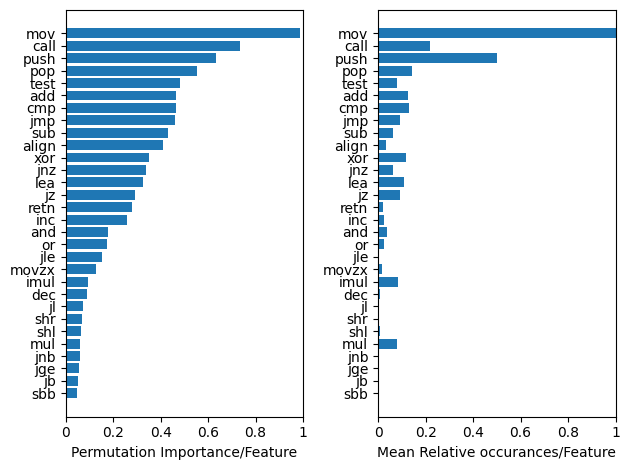

In [14]:
#  Permutation Importance Graphs Plotted and Printed Here - Compare these with how many files these instructions actually occur in

if(getMetrics == True): permutationImportanceGraphPlot(model, trainDFWithoutLabels, trainLabels, finalDF)

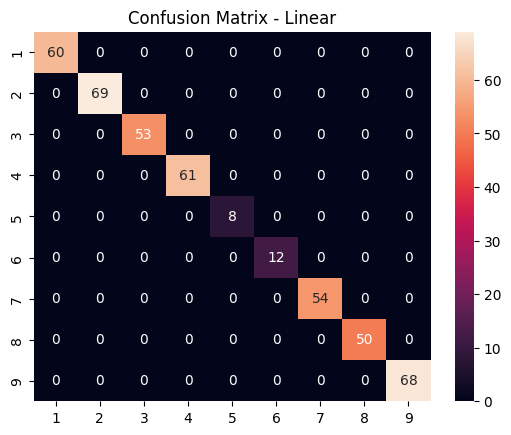

In [15]:
# Confusion Matrix Plotted and Printed Here

if(getMetrics == True): createSVMConfusionMatrix(svmTestDatasetPrediction,classList)

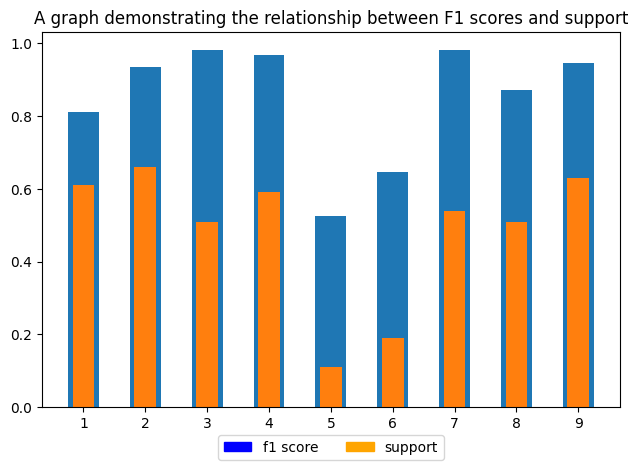

In [16]:
# Raw Classification Report stats graphed out here

if(getMetrics == True): classificationReportGenerateGraph(testLabels, svmTestDatasetPrediction)